#Transfer Learning with Med MNIST.

In this assignment you will use transfer learning to train a model of your choice on a sub-dataset from the [MedMNIST datasets](https://medmnist.com/). ![](https://github.com/tonyscan6003/etivities/blob/main/medmnist.JPG?raw=true)

* The [MedMNIST package](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) allows the data to be imported directly as a pytorch dataset.

* You may select any of the datasets using Multi-class/binary classification. The goal is to acheve accuracy levels comparable to the benchmark results shown on the medmnist site. Dataloading for pytorch is setup in the notebook, you wil need to modify the code slightly depending on your dataset of choice.

* Some datasets use black and white images, so you will need to [at least concatenate](https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a) the input image channels (to 3 channels) for compatibility with the models pre-trained on imageNet.

* Some of the MedMNIST datasets don't contain too much data so Data augmentation may be essentila essential to avoid overfitting. In pytorch data augmentation is performed using the [transforms.v2](https://pytorch.org/vision/main/transforms.html) modules.

* In this notebook: You will need to import a model, and perform training. Tranfer Learning for computer vision is detailed [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

* [Tensorboard can be imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.

* Please only include one example of transfer learning in the submitted notebook. Making sure training curves/results are clearly visible. If you have trained additional transfer learning models (i.e. that were less successful) please add this as a table or report at the end of the notebook and/or in your final forum post.




# 1. Install & Import Packages

In [136]:
!pip install medmnist
!pip install torchinfo


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [137]:
import torch
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad
import matplotlib.pyplot as plt
import numpy as np

import os
from torchinfo import summary
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.nn.utils import clip_grad_norm_

import torch

## 2. Setup & Import Dataset
The [MedMNSIT](https://medmnist.com/) package (imported above) makes available several medical datasets available to access.

You can change the `data_flag` variable (dataset names are all lower case letters) to the dataset of your choice (Take care to note the parameters e.g. number of input channels below that will affect your model)



In [138]:
import medmnist
from medmnist import INFO, Evaluator

data_flag = 'dermamnist'
download = True

BATCH_SIZE = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
classes = info['label']

print('Type of Machine Learning Task = ',task)
print('Number of Input Data Channels = ',n_channels)
print('Number of Classes = ',n_classes)
print('The batch size for this dataset will be = ',BATCH_SIZE)

DataClass = getattr(medmnist, info['python_class'])

Type of Machine Learning Task =  multi-class
Number of Input Data Channels =  3
Number of Classes =  7
The batch size for this dataset will be =  64


In [139]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

torch.manual_seed(42)

if device == 'cuda':
    # this part was added as I noticed with each run i would get a different result
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    print("CuDNN benchmark / deterministic mode ENABLED") # since we have a fixed input of images may as well put the machine to work - faster convolution


Using cuda device
CuDNN benchmark / deterministic mode ENABLED


In [140]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def fetch_accuracy(y_true, y_pred):

    acc_A = accuracy_score(y_true, y_pred)
    f1_macro_A = f1_score(y_true, y_pred, average='macro')

    print(classification_report(y_true, y_pred))
    print(f"Model A → Acc: {acc_A:.3f}, Macro-F1: {f1_macro_A:.3f}")

def fetch_train_object(preprocess, batch_size, size, num_workers, pin_memory, download) :

    train_dataset = DataClass(split='train', transform=preprocess, download=download, size=size, mmap_mode='r')

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory,
                                  prefetch_factor=4,      # range 2- 8
                                  persistent_workers=True)

    print(f'Train Samples {len(train_dataloader.dataset)} - Train Batches {len(train_dataloader)}')

    return train_dataset, train_dataloader

def fetch_test_object(preprocess, batch_size, size, num_workers, pin_memory,download):

    test_dataset = DataClass(split='test', transform=preprocess, download=download, size=size, mmap_mode='r')

    test_dataloader =  DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=pin_memory,
                                 prefetch_factor=4,      # range 2- 8
                                 persistent_workers=True)

    print(f'Test Samples {len(test_dataloader.dataset)} - Test Batches {len(test_dataloader)}')

    return test_dataset, test_dataloader

def fetch_v_object(preprocess, batch_size, size, num_workers, pin_memory, download):

    val_dataset = DataClass(split='val', transform=preprocess, download=download, size=size, mmap_mode='r')

    val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=pin_memory,
                                 prefetch_factor=4,      # range 2- 8
                                 persistent_workers=True)

    print(f'Val Samples {len(val_dataloader.dataset)} - Val Batches {len(val_dataloader)}')

    return val_dataset, val_dataloader

Setup your Medmnist dataset.
* The convolution part of pre-trained networks (such as resnet) are compatable with any size input image. However they were trained on 224 x 224 size images, with early layers finding small scale features and deeper layers finding large scale features.
* For this transfer learning application to medical data, the gap between the original ImageNet domain and the medical images is wide. Therefore the size/scale of the input images is less important, however in general we would expect better performance with the larger input images (as they contain more features at different scales).
* You can add the `size=224` parameter to the dataset object calls, to load full size images. Only do this once you are confident in your training methodology (or if the dataset is small), as training with full size images will take longer.


Plot some example augmented images

# 3. Define Transfer Learning model
Pytorch has an inbuilt [models package](https://pytorch.org/vision/stable/models.html) that allows loading of popular models with pre-trained weights.

* We want to add an additional classifier stage (to the output of the network). How to setup the [model is detailed here](https://discuss.pytorch.org/t/load-only-a-part-of-the-network-with-pretrained-weights/88397/2).
* This additional classifier may just be a single layer or a cascade of fully connected layers with dropout.
* Note that the number of parameters in the convolutional part of the model will be same no what the input size is set to. However the output feature map size will vary with input image size (small for small image, large for large image). This means the number of parameters in the additional classifier will change depending on input image size.


In [141]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import AlexNet_Weights

pretrained_alexnet = models.alexnet(weights="IMAGENET1K_V1")
weights = AlexNet_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

class AssigmentAlexNet(nn.Module):
    def __init__(self, pretrained_model, num_classes=2, freeze_backbone=True):
        super(AssigmentAlexNet, self).__init__()

        # set features and avgpool from the pretrained model
        self.features = pretrained_model.features
        self.avgpool = pretrained_model.avgpool

        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 512), # Input size to classifier: 256 * 6 * 6 = 9216
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # only new layers learn
        if freeze_backbone:
            for param in self.features.parameters():  #Freeze feature extractor
                param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)        # (B, 9216)
        x = self.classifier(x)
        return x

model = AssigmentAlexNet(pretrained_model=pretrained_alexnet, num_classes=n_classes)
model = model.cuda()

In [142]:
num_workers = min(8, os.cpu_count() or 1)
pin_memory = (device == 'cuda')

train_dataset, train_dataloader = fetch_train_object(preprocess, BATCH_SIZE, 224, num_workers, pin_memory, download)
test_dataset, test_dataloader = fetch_test_object(preprocess, BATCH_SIZE, 224, num_workers, pin_memory, download)
val_dataset, val_dataloader = fetch_v_object(preprocess, BATCH_SIZE, 224, num_workers, pin_memory, download)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Train Samples 7007 - Train Batches 110
Test Samples 2005 - Test Batches 32
Val Samples 1003 - Val Batches 16
Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 1]) torch.int64


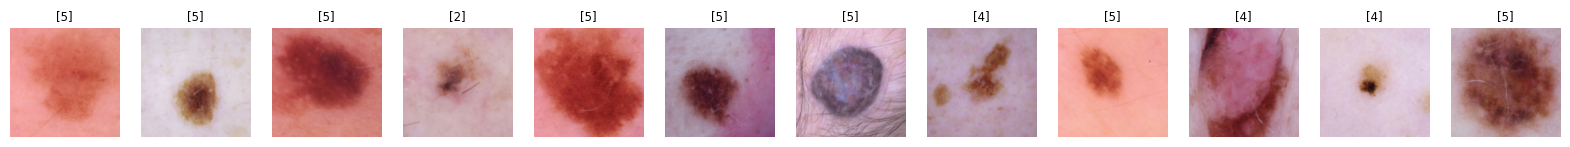

In [143]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1

In [144]:
from torch.utils.tensorboard import SummaryWriter
import time

run_name = f"exp_{int(time.time())}"
writer = SummaryWriter(log_dir=f"runs_assigment2/{run_name}")

# 4. Optimisation & Training Loop

Define a training loop that prints the loss from the training and validation set at least every epoch.
* You may choose to make the validation loss calculations more frequent so you can ensure training is progressing satisfactorily (especially with larger datasets).

* You can use tensorboard to visualise the [loss curves](https://pytorch.org/docs/stable/tensorboard.html))

* For multi-class classification classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* You may  have to use [torch.squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html) to reduce the dimensionality of the label tensor before passing it to the loss function (this due to how the dataset is configured and the loss will only accept 0D or 1D inputs)

In [145]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

# Train
model.train()
for epoch in range(10):
    for images, labels in train_dataloader:
        images, labels = images.cuda(), labels.cuda()

        if labels.dim() > 1:
            labels = labels.squeeze(1)  # handles (N,1) → (N,)

        optimizer.zero_grad()
        outputs = model(images)           # ← already normalized!
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    writer.add_scalar(f"Epoch vs Loss:", epoch+1, loss.item())

y_true = []
y_pred = []

# Validate
model.eval()
correct = total = 0
with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.cuda(), labels.cuda()

        preds = model(images).argmax(1)

        correct += (preds == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        total += labels.size(0)
writer.add_scalar(f"Val Acc:", 100*correct/total)

Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb)). A [Pytorch tutorial](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) shows how to setup the training and validation loop with pytorch.


# 5. Evaluate Model
You will need to setup an evaluation loop for the model to assess it's performance on the test dataset.

You may also obtain a classification report after final evaluation of the test dataset with the model using the code below. A confusion matrix can also be obtained and we will plot a few example images.



              precision    recall  f1-score   support

           0       0.62      0.48      0.54        33
           1       0.72      0.75      0.74        52
           2       0.66      0.52      0.58       110
           3       0.83      0.42      0.56        12
           4       0.63      0.47      0.54       111
           5       0.86      0.95      0.90       671
           6       0.89      0.57      0.70        14

    accuracy                           0.81      1003
   macro avg       0.74      0.59      0.65      1003
weighted avg       0.80      0.81      0.80      1003

Model A → Acc: 0.810, Macro-F1: 0.649


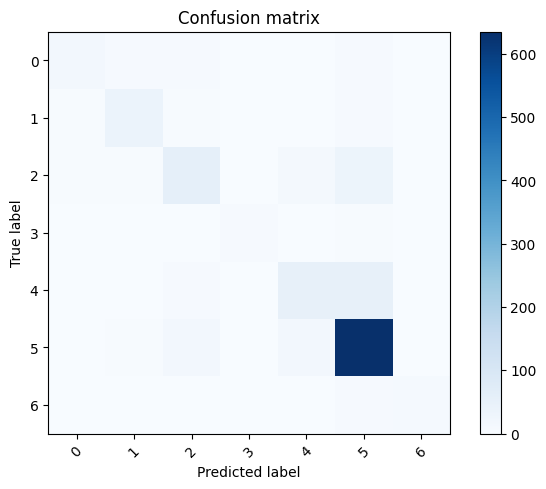

In [146]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

fetch_accuracy(y_true, y_pred)
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes)

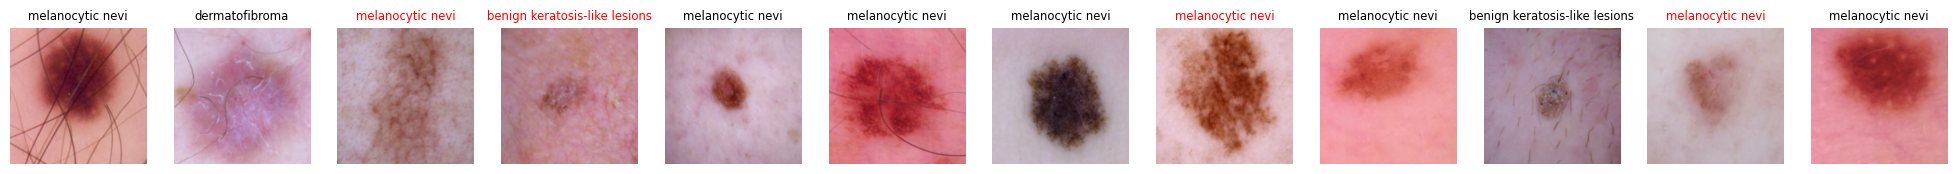

In [152]:
# Output next batch from dataloader
dataiter = iter(test_dataloader)
image_batch, labels_batch = next(dataiter)

# Pass batch through model
model.eval()
image_batch = image_batch.to(device)
pred_logit = model(image_batch)


# Use matplotlib to plot a sample of images
import matplotlib.pyplot as plt
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(25,10))


for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image.to('cpu'),(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")

  predicted_idx = pred_logit[i,:].argmax(0).item()   # convert tensor → int
  actual_idx = labels_batch[i].item()               # convert tensor → int
  predicted, actual = classes[str(predicted_idx)], classes[str(actual_idx)]

  color = 'black' if predicted == actual else 'red'
  axarr[i].set_title(predicted,fontsize='small', color=color)
  i = i+1

 # Comments about your Approach